In [1]:
import json
import csv
import os
import scipy.fft
import numpy as np
import pandas as pd
import statistics
import matplotlib.pyplot as plt
from pandas import DataFrame
from scipy.signal import find_peaks
from scipy.signal import butter, lfilter, filtfilt, savgol_filter
#try
from detecta import detect_peaks
from scipy.signal import savgol_filter
from scipy import stats
from scipy import integrate


In [2]:
def myfft(y):
    N = len(y)
    T = 1.0 / 100.0
    x = np.linspace(0.0, N*T, N)
    y_f = scipy.fft.fft(y)
    x_f = np.linspace(0.0, 1.0/(2.0*T), N//2)
    #plt.plot(x_f, 2.0/N * np.abs(y_f[:N//2]))
    #plt.show()
    return x_f,2.0/N * np.abs(y_f[:N//2])
def low_pass_filter(x, cutoff, fs, order,type='float'):
    if type == 'str':
        x = [float(dx) for dx in x]
    nyquist = fs / 2
    b, a = butter(order, cutoff / nyquist)

    filtered = filtfilt(b, a, x, method='gust')
    if type == 'str':
        return [str(s) for s in filtered]
    else:
        return filtered
def NormaliseCrossCorrelation(a,v):
    M = len(a)
    N = len(v)

    if type(a) is list: 
        a = np.array(a)
    if type(v) is list: 
        v = np.array(v)
    
    v_mu = np.mean(v)
    print(M-N+1)
    ncc_series = []
    for i in range(M-N+1):
        _a = a[i:i+N]
        a_sum = _a - np.mean(_a)
        v_sum = v - v_mu
        nr = 1/N * np.sum(a_sum*v_sum) / np.sqrt(np.var(_a)*np.var(v))
        ncc_series.append(nr)

    return ncc_series


In [43]:
#try new readfile
origin_path = './05.台南北華里/000可用data/021'
all_file_name = os.listdir(origin_path)
print(all_file_name)
for _ in all_file_name:
    filename = _.split('.')[1]
    if filename != 'json':all_file_name.remove(f'{_}')
print(all_file_name)
path_1 = all_file_name[0]
path_2 = all_file_name[1]
print(path_1,path_2)
filename = origin_path.split('/')
filename = filename[-1]
print(filename)

['WS_2022-10-06_11-53-07-588_Acc.json', 'WS_2022-10-13_12-03-56-162_Acc.json']
['WS_2022-10-06_11-53-07-588_Acc.json', 'WS_2022-10-13_12-03-56-162_Acc.json']
WS_2022-10-06_11-53-07-588_Acc.json WS_2022-10-13_12-03-56-162_Acc.json
021


./05.台南北華里/000可用data/021/WS_2022-10-06_11-53-07-588_Acc.json
309.834278978598


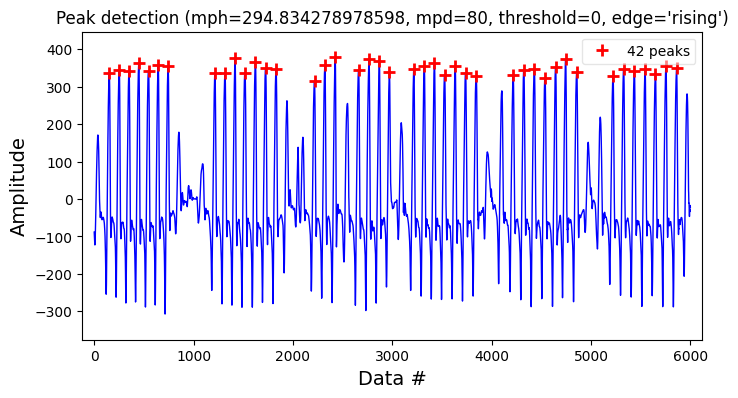

[151, 252, 350, 449, 547, 644]
210.67429908054964


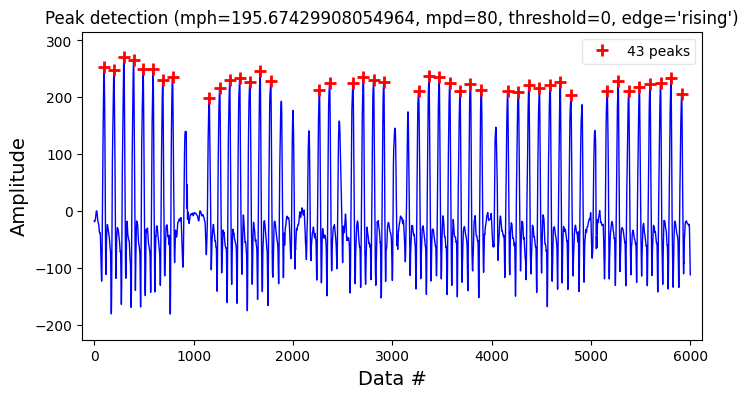

[99, 197, 299, 396, 492, 593]


In [44]:
path = f'{origin_path}/{path_1}'
print(path)
with open(path) as file:
    data = json.load(file)
data['LeftFootGyro']['z'] = savgol_filter(data['LeftFootGyro']['z'], 11, 3)
#Left
x = detect_peaks(data['LeftFootGyro']['z'][0:6000],mpd = 80 )
a=[]
for i in x:
    a.append(data['LeftFootGyro']['z'][i]) 
print(statistics.mean(a))
try_peak = detect_peaks(data['LeftFootGyro']['z'][0:6000],mph = statistics.mean(a)-15,mpd = 80 ,kpsh=True,show=True)
Left_five_steps=[]
for i in range(len(try_peak)):
    if try_peak[i+1]-try_peak[i] < 200: Left_five_steps.append(try_peak[i])
    if try_peak[i+1]-try_peak[i] >= 200 and len(Left_five_steps)<5:Left_five_steps=[]
    if len(Left_five_steps)==5: Left_five_steps.append(try_peak[i+1]);break 
print(Left_five_steps)

#Right
data['RightFootGyro']['z'] = np.array(data['RightFootGyro']['z']) * (-1)
data['RightFootGyro']['z'] = savgol_filter(data['RightFootGyro']['z'], 11, 3)
x = detect_peaks(data['RightFootGyro']['z'][0:6000],mpd = 80 )
a=[]
for i in x:
    a.append(data['RightFootGyro']['z'][i]) 
print(statistics.mean(a))
try_peak = detect_peaks(data['RightFootGyro']['z'][0:6000],mph = statistics.mean(a)-15,mpd = 80 ,kpsh=True,show=True)
Right_five_steps=[]
for i in range(len(try_peak)):
    if try_peak[i+1]-try_peak[i] < 200: Right_five_steps.append(try_peak[i])
    if try_peak[i+1]-try_peak[i] >= 200 and len(Right_five_steps)<5:Right_five_steps=[]
    if len(Right_five_steps)==5: Right_five_steps.append(try_peak[i+1]);break 
print(Right_five_steps)


In [45]:
#Left x,y,z
left_acc_fft_x = low_pass_filter(data['LeftFootAcc']['x'],3.3,80,4)
left_acc_fft_y = low_pass_filter(data['LeftFootAcc']['y'],3.3,80,4)
left_acc_fft_z = low_pass_filter(data['LeftFootAcc']['z'],3.3,80,4)
#Right x,y,z
right_acc_fft_x = low_pass_filter(data['RightFootAcc']['x'],3.3,80,4)
right_acc_fft_y = low_pass_filter(data['RightFootAcc']['y'],3.3,80,4)
right_acc_fft_z = low_pass_filter(data['RightFootAcc']['z'],3.3,80,4)

#訊號倒置
left_acc_fft_x = np.array(left_acc_fft_x) * (-1)    
left_acc_fft_y = np.array(left_acc_fft_y) * (-1)  
left_acc_fft_z = np.array(left_acc_fft_z) * (-1)
#RSS
left_rss = np.sqrt(np.array(left_acc_fft_x)**2 + np.array(left_acc_fft_y)**2 + np.array(left_acc_fft_z)**2)
right_rss = np.sqrt(np.array(right_acc_fft_x)**2 + np.array(right_acc_fft_y)**2 + np.array(right_acc_fft_z)**2)
# plt.plot(left_rss[0:1000])
# plt.title('left_rss 0~10sec')
# plt.show()
# plt.plot(right_rss[0:1000])
# plt.title('right_rss 0~10sec')


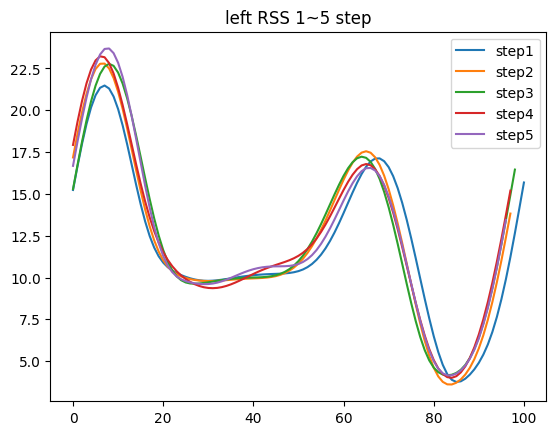

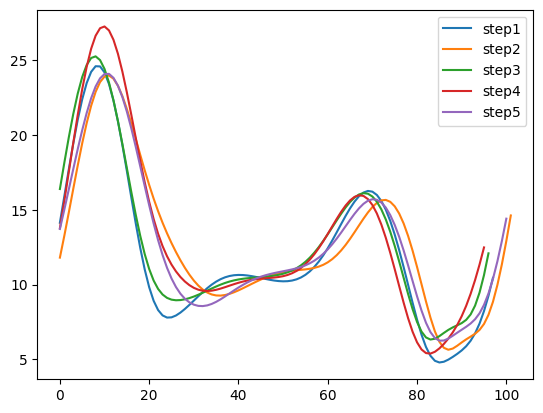

In [46]:
#left five steps
left_five = left_rss[Left_five_steps[0]:Left_five_steps[-1]]
left_t1 = left_rss[Left_five_steps[0]:Left_five_steps[1]]
left_t2 = left_rss[Left_five_steps[1]:Left_five_steps[2]]
left_t3 = left_rss[Left_five_steps[2]:Left_five_steps[3]]
left_t4 = left_rss[Left_five_steps[3]:Left_five_steps[4]]
left_t5 = left_rss[Left_five_steps[4]:Left_five_steps[5]]
plt.plot(left_t1,label='step1')
plt.plot(left_t2,label='step2')
plt.plot(left_t3,label='step3')
plt.plot(left_t4,label='step4')
plt.plot(left_t5,label='step5')
plt.title('left RSS 1~5 step')
# for i in range(5):
#     locals()['t'+str(i)] = i+1 
#     label = locals()['t'+str(i)]
#     locals()['t'+str(i)] = left_rss[Left_five_steps[i]:Left_five_steps[i+1]]
#     plt.plot(locals()['t'+str(i)],label=f't{label}')
plt.legend()
plt.show()

#right five steps
right_five = right_rss[Right_five_steps[0]:Right_five_steps[-1]]    
right_t1 = right_rss[Right_five_steps[0]:Right_five_steps[1]]
right_t2 = right_rss[Right_five_steps[1]:Right_five_steps[2]]
right_t3 = right_rss[Right_five_steps[2]:Right_five_steps[3]]
right_t4 = right_rss[Right_five_steps[3]:Right_five_steps[4]]
right_t5 = right_rss[Right_five_steps[4]:Right_five_steps[5]]
plt.plot(right_t1,label='step1')
plt.plot(right_t2,label='step2')
plt.plot(right_t3,label='step3')
plt.plot(right_t4,label='step4')
plt.plot(right_t5,label='step5')

# for i in range(5):
#     locals()['t'+str(i)] = i+1 
#     label = locals()['t'+str(i)]
#     locals()['t'+str(i)] = left_rss[Left_five_steps[i]:Left_five_steps[i+1]]
#     plt.plot(locals()['t'+str(i)],label=f't{label}')
plt.legend()
plt.show()

切割

393
396
395
396
397
367 367 367 367 367 

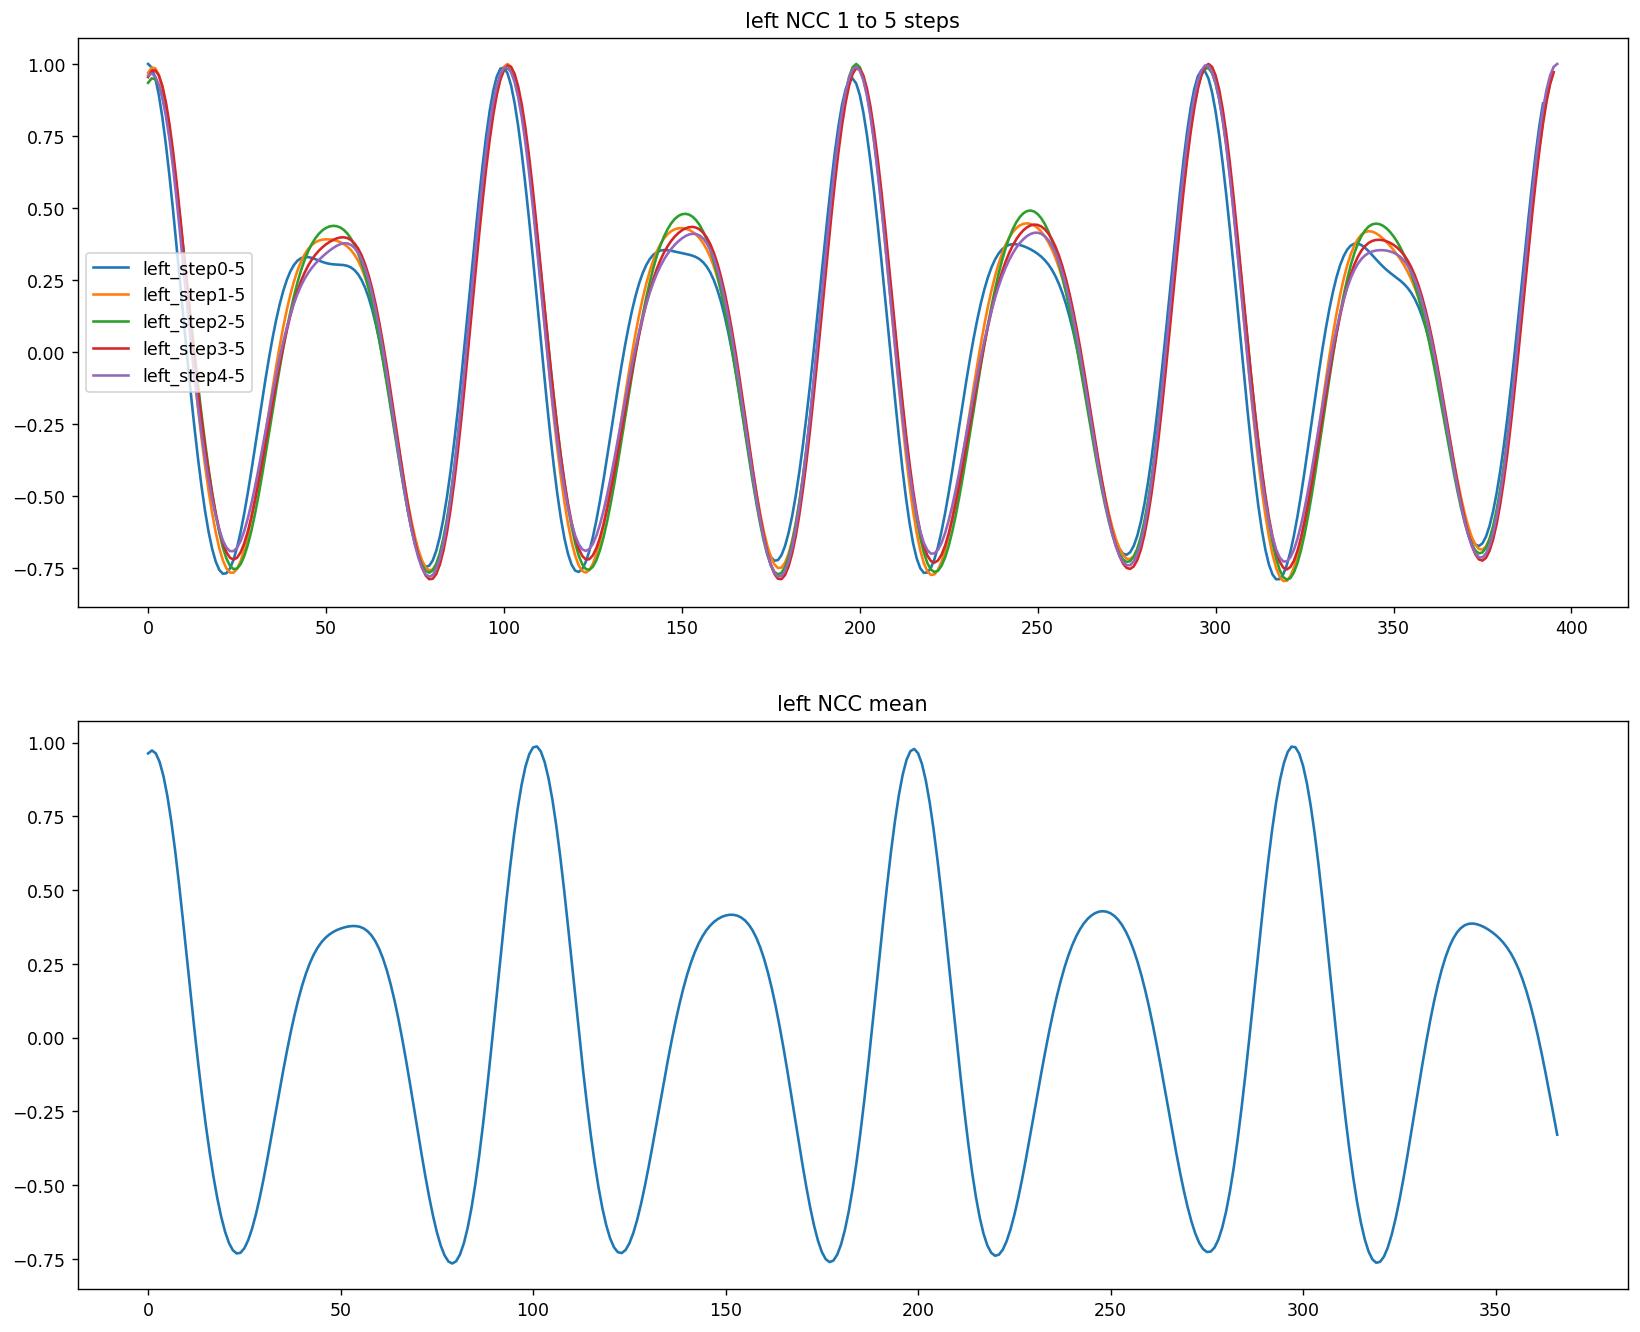

397
393
398
399
394
367 367 367 367 367 

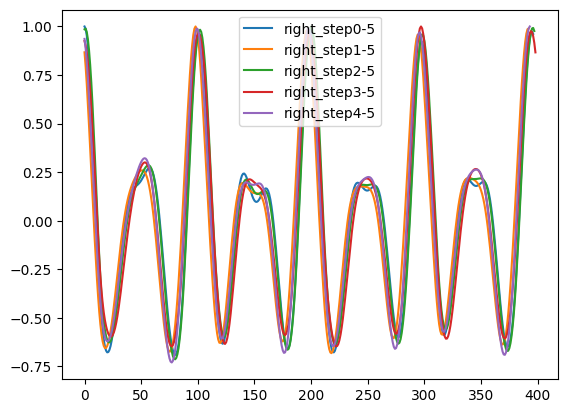

In [47]:
#left NCC(CrossCorrelation)
left_ncc_list = []
plt.figure(figsize=(16,13),dpi=125)
ax1 = plt.subplot(211)
for i in range(5):
    a = NormaliseCrossCorrelation(left_five,left_rss[Left_five_steps[i]:Left_five_steps[i+1]])
    left_ncc_list.append(a[0:367])
    plt.plot(a,label=f'left_step{i}-5')
    # plt.show()
plt.legend()
for _ in range(5):print(len(left_ncc_list[_]),end=' ')
plt.title('left NCC 1 to 5 steps')
#left Ncc mean
ax2 = plt.subplot(212)
left_ncc1 = np.mean(left_ncc_list, axis=0)
#plt.figure(figsize=(20,1),dpi=125)
plt.plot(left_ncc1)
plt.title('left NCC mean')
plt.show()

#right NCC(CrossCorrelation)
right_ncc_list = []
for i in range(5):
    a = NormaliseCrossCorrelation(right_five,right_rss[Right_five_steps[i]:Right_five_steps[i+1]])
    right_ncc_list.append(a[0:367])
    plt.plot(a,label=f'right_step{i}-5')
plt.legend()
for _ in range(5):print(len(right_ncc_list[_]),end=' ')
plt.show()

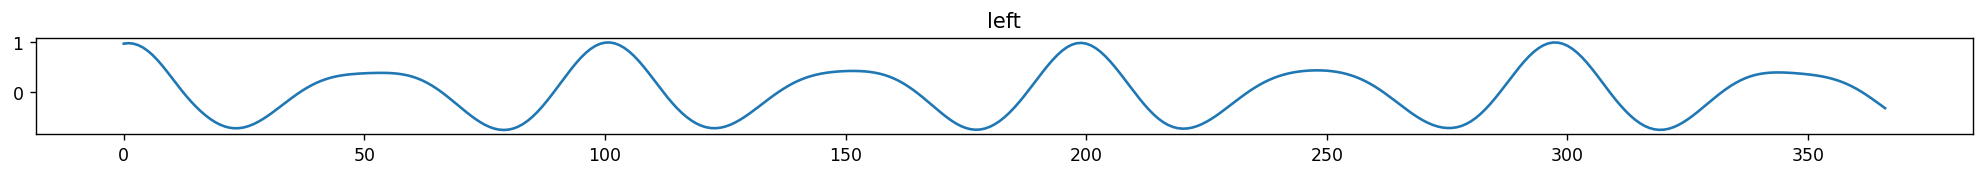

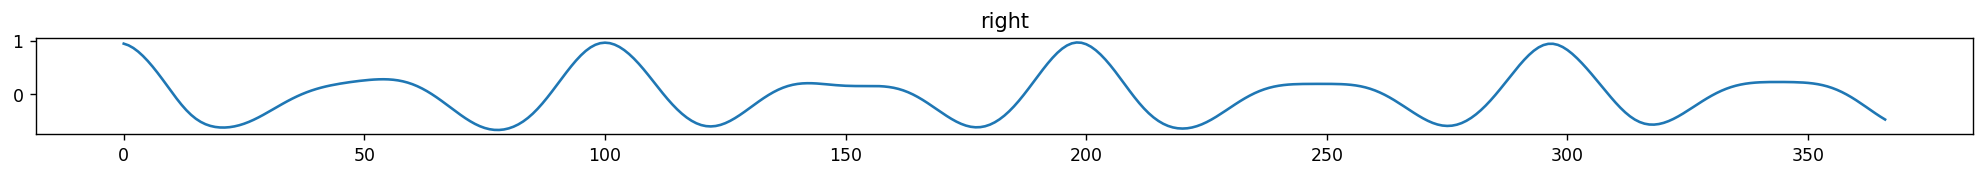

Ttest_relResult(statistic=2.1134915421018388, pvalue=0.03523494145660695)

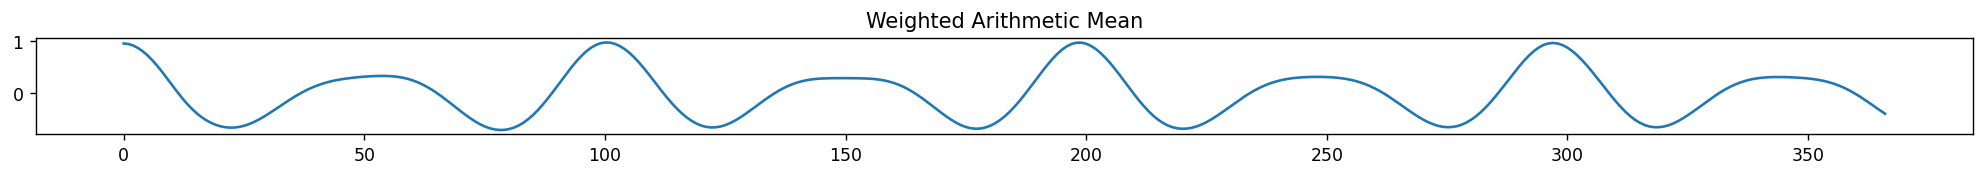

In [48]:
#left Ncc mean
left_ncc1 = np.mean(left_ncc_list, axis=0)
plt.figure(figsize=(20,1),dpi=125)
plt.plot(left_ncc1)
plt.title('left')
plt.show()
#right Ncc mean
right_ncc1 = np.mean(right_ncc_list, axis=0)
plt.figure(figsize=(20,1),dpi=125)
plt.plot(right_ncc1)
plt.title('right')
plt.show()
# total_ncc1 = [left_ncc1,right_ncc1]
# mean_ncc1 = np.mean(total_ncc1,axis=0)
# plt.figure(figsize=(20,1),dpi=125)
# plt.plot(mean_ncc1)
w1 = 0.5
w2 = 0.5
final_score = (w1 * left_ncc1 + w2 * right_ncc1) / (w1 + w2)
plt.figure(figsize=(20,1),dpi=125)
plt.plot(final_score)
plt.title('Weighted Arithmetic Mean')
stats.ttest_rel(left_ncc1, right_ncc1)

In [49]:
#left(不分)
y = detect_peaks(left_ncc1*(-1),mpd = 35 )
left_ncc_area_once=[]
for _ in range(len(y)):
    try:
        x_a=np.arange(y[_],y[_+1],1)
        y_a=left_ncc1[y[_]:y[_+1]]
        area = integrate.trapz(y_a, x_a)
        print(f'left 下面積{_+1}為：', area)
        left_ncc_area_once.append(abs(area))
    except:break
print(left_ncc_area_once)

left 下面積1為： -3.4060878660434764
left 下面積2為： 4.229547028334744
left 下面積3為： -2.2512625625092806
left 下面積4為： 3.995984775951407
left 下面積5為： -3.06434000952441
left 下面積6為： 4.334611023949372
[3.4060878660434764, 4.229547028334744, 2.2512625625092806, 3.995984775951407, 3.06434000952441, 4.334611023949372]


X 軸: [ 23  79 123 177 220 275 319]
[-0.73216544 -0.72985502 -0.71453555 -0.68697236 -0.64822895 -0.59960997
 -0.54260596 -0.47884136 -0.41002469 -0.3378991  -0.26419249 -0.19056752
 -0.11857262 -0.04959577  0.01517671  0.07479421  0.12856616  0.17607464
  0.21717357  0.2519739   0.28081477  0.30422234  0.32285843  0.33746226
  0.34878883  0.357548    0.36434785  0.3696461   0.37371241  0.37660415
  0.37815726  0.37799305  0.37554101  0.37007657  0.36077181  0.34675601
  0.32718166  0.30129135  0.26848045  0.22835124  0.18075543  0.1258233
  0.06397942 -0.00405453 -0.07726905 -0.1543877  -0.23389963 -0.31410328
 -0.39315971 -0.46915291 -0.54015345 -0.60428159 -0.65976638 -0.7049969
 -0.73856237 -0.75927836]
left 下面積1為： -3.4060878660434764
left 下面積2為： 4.229547028334744
left 下面積3為： -2.2512625625092806
left 下面積4為： 3.995984775951407
left 下面積5為： -3.06434000952441
left 下面積6為： 4.334611023949372
[3.4060878660434764, 2.2512625625092806, 3.06434000952441]
[4.229547028334744, 3.995984775951407, 4.

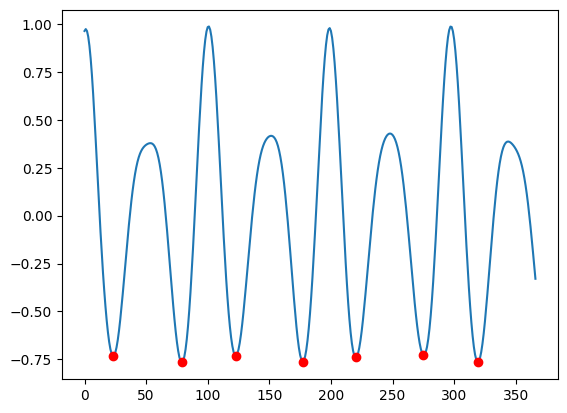

In [50]:
#left(分)
y = detect_peaks(left_ncc1*(-1),mpd = 35 )
print('X 軸:',y)
plt.plot(left_ncc1)
plt.plot(y,left_ncc1[y],'o',color='r')
print(left_ncc1[y[0]:y[1]]) #y值
left_ncc_area1 = []
left_ncc_area2 = []
for _ in range(len(y)):
    try:
        x_a=np.arange(y[_],y[_+1],1)
        y_a=left_ncc1[y[_]:y[_+1]]
        area = integrate.trapz(y_a, x_a)
        print(f'left 下面積{_+1}為：', area)
    except:break
    if (_+1)%2 == 1:left_ncc_area1.append(abs(area))
    if (_+1)%2 == 0:left_ncc_area2.append(abs(area))
print(left_ncc_area1)
print(left_ncc_area2)
left_small_ncc1 = left_ncc_area1
left_big_ncc1 = left_ncc_area2
left_small_ncc1_st = [_ for _ in y if int(list(np.where(y==_))[0])%2==1]
print(left_small_ncc1_st)
left_big_ncc1_st = [_ for _ in y if int(list(np.where(y==_))[0])%2==0]
print(left_big_ncc1_st)
left_small_ncc1_st = left_small_ncc1_st-left_big_ncc1_st[0]
left_big_ncc1_st = (left_big_ncc1_st-left_big_ncc1_st[0])[1::]
print(left_big_ncc1_st)

In [51]:
#right(不分) 
y = detect_peaks(right_ncc1*(-1),mpd = 35 )
right_ncc_area_once=[]
for _ in range(len(y)):
    try:
        x_b=np.arange(y[_],y[_+1],1)
        y_b=right_ncc1[y[_]:y[_+1]]
        area = integrate.trapz(y_b, x_b)
        print(f'right 下面積{_+1}為：', area)
        right_ncc_area_once.append(abs(area))
    except:break
print(right_ncc_area_once)

right 下面積1為： -5.895610467633777
right 下面積2為： 6.120816734597312
right 下面積3為： -4.194166368345613
right 下面積4為： 5.2309561253867125
right 下面積5為： -5.5256903431568585
right 下面積6為： 6.331345207906111
[5.895610467633777, 6.120816734597312, 4.194166368345613, 5.2309561253867125, 5.5256903431568585, 6.331345207906111]


[ 21  78 122 177 220 275 318]
[-6.25549228e-01 -6.18632126e-01 -6.04230717e-01 -5.82742046e-01
 -5.54577900e-01 -5.20267487e-01 -4.80504997e-01 -4.36151759e-01
 -3.88209643e-01 -3.37777882e-01 -2.86000385e-01 -2.34008586e-01
 -1.82864923e-01 -1.33512175e-01 -8.67332782e-02 -4.31246657e-02
 -3.08426579e-03  3.31864803e-02  6.56684160e-02  9.45007097e-02
  1.19949693e-01  1.42372936e-01  1.62180812e-01  1.79797593e-01
  1.95623950e-01  2.10002490e-01  2.23187768e-01  2.35321942e-01
  2.46417083e-01  2.56344899e-01  2.64834546e-01  2.71479014e-01
  2.75750450e-01  2.77024528e-01  2.74613577e-01  2.67807592e-01
  2.55921329e-01  2.38344688e-01  2.14592499e-01  1.84349216e-01
  1.47504134e-01  1.04173880e-01  5.47109455e-02 -3.00542697e-04
 -6.00586077e-02 -1.23562605e-01 -1.89634286e-01 -2.56939363e-01
 -3.24011278e-01 -3.89281881e-01 -4.51125147e-01 -5.07918381e-01
 -5.58119789e-01 -6.00352850e-01 -6.33480184e-01 -6.56647435e-01
 -6.69283684e-01]
right 下面積1為： -5.895610467633777
right 下面積2

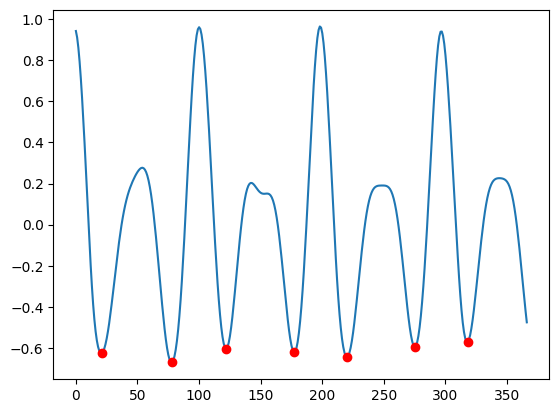

In [52]:
#right (分)
x = detect_peaks(right_ncc1,mpd = 80 )
y = detect_peaks(right_ncc1*(-1),mpd = 35 )
print(y)
plt.plot(right_ncc1)
plt.plot(y,right_ncc1[y],'o',color='r')
print(right_ncc1[y[0]:y[1]]) #y值
right_ncc_area1 = []
right_ncc_area2 = []
for _ in range(len(y)):
    try:
        x_b=np.arange(y[_],y[_+1],1)
        y_b=right_ncc1[y[_]:y[_+1]]
        area = integrate.trapz(y_b, x_b)
        print(f'right 下面積{_+1}為：', area)
    except:break
    if (_+1)%2 == 1:right_ncc_area1.append(abs(area))
    if (_+1)%2 == 0:right_ncc_area2.append(abs(area))
x_b=np.arange(y[0],y[1],1)
y_b=right_ncc1[y[0]:y[1]]
area = integrate.trapz(y_b, x_b)
print('right 下面積為：', area)
print(right_ncc_area1)
print(right_ncc_area2)
right_small_ncc1 = right_ncc_area1
right_big_ncc1 = right_ncc_area2

right_small_ncc1_st = [_ for _ in y if int(list(np.where(y==_))[0])%2==1]
print(right_small_ncc1_st)
right_big_ncc1_st = [_ for _ in y if int(list(np.where(y==_))[0])%2==0]
print(right_big_ncc1_st)
right_small_ncc1_st = right_small_ncc1_st-right_big_ncc1_st[0]
right_big_ncc1_st = (right_big_ncc1_st-right_big_ncc1_st[0])[1::]
print(right_big_ncc1_st)

(前次)儲存NCC面積序列至.csv

In [53]:
print(left_ncc_area1)
#Left
left_area = []
if isinstance(left_ncc_area1[0],float) is True:
    for _ in range(len(left_ncc_area1) + len(left_ncc_area2)):
        try:
            left_area.append(left_ncc_area1[_])
            left_area.append(left_ncc_area2[_])
        except:break
    left_area.insert(0,'前次左腳NCC面積序列')
with open (f'{origin_path}/{filename}.csv','w') as f:
    writer = csv.writer(f)
    writer.writerow(left_area)
#Right
right_area = []
if isinstance(right_ncc_area1[0],float) is True:
    for _ in range(len(right_ncc_area1) + len(right_ncc_area2)):
        try:
            right_area.append(right_ncc_area1[_])
            right_area.append(right_ncc_area2[_])
        except:break
    right_area.insert(0,'前次右腳NCC面積序列')
with open (f'{origin_path}/{filename}.csv','a') as f:
    writer = csv.writer(f)
    writer.writerow(right_area)
print(left_area)
print(origin_path)

[3.4060878660434764, 2.2512625625092806, 3.06434000952441]
['前次左腳NCC面積序列', 3.4060878660434764, 4.229547028334744, 2.2512625625092806, 3.995984775951407, 3.06434000952441, 4.334611023949372]
./05.台南北華里/000可用data/021


第二組數據

268.34234947442565


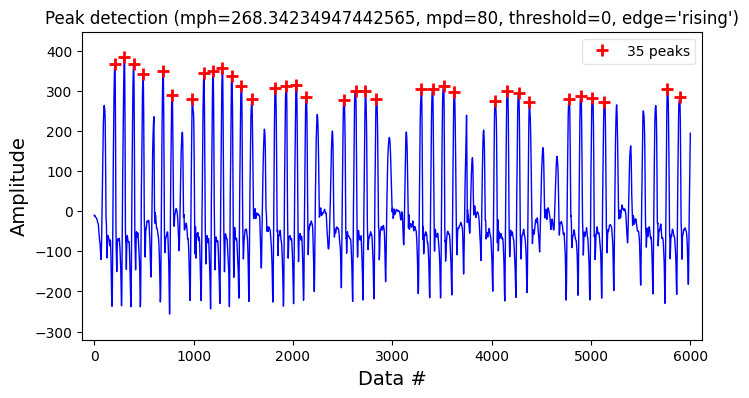

[987, 1104, 1195, 1290, 1383, 1479]
292.35983474073174


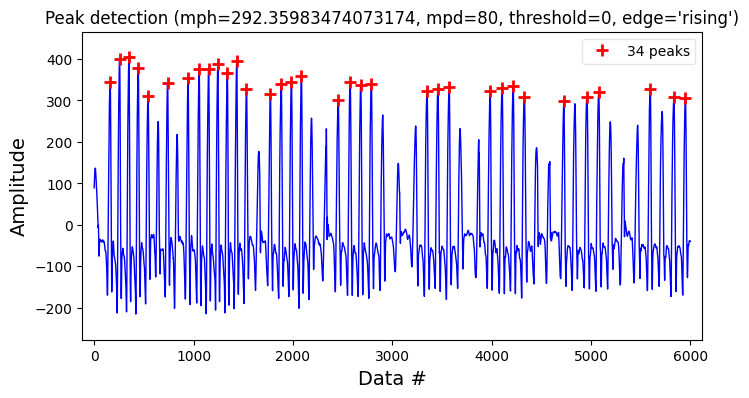

[160, 255, 349, 443, 541, 738]


In [54]:
path = f'{origin_path}/{path_2}'
with open(path) as file:
    data = json.load(file)
#Left
data['LeftFootGyro']['z'] = savgol_filter(data['LeftFootGyro']['z'], 11, 3)
x = detect_peaks(data['LeftFootGyro']['z'][0:6000],mpd = 80 )
a=[]
for i in x:
    a.append(data['LeftFootGyro']['z'][i]) 
print(statistics.mean(a))
try_peak = detect_peaks(data['LeftFootGyro']['z'][0:6000],mph = statistics.mean(a)-0,mpd = 80 ,kpsh=True,show=True)
Left_five_steps=[]
for i in range(len(try_peak)):
    if try_peak[i+1]-try_peak[i] < 200: Left_five_steps.append(try_peak[i])
    if try_peak[i+1]-try_peak[i] >= 200 and len(Left_five_steps)<5:Left_five_steps=[]
    if len(Left_five_steps)==5: Left_five_steps.append(try_peak[i+1]);break 
print(Left_five_steps)

#Right
data['RightFootGyro']['z'] = np.array(data['RightFootGyro']['z']) * (-1)
data['RightFootGyro']['z'] = savgol_filter(data['RightFootGyro']['z'], 11, 3)
x = detect_peaks(data['RightFootGyro']['z'][0:6000],mpd = 80 )
a=[]
for i in x:
    a.append(data['RightFootGyro']['z'][i]) 
print(statistics.mean(a))
try_peak = detect_peaks(data['RightFootGyro']['z'][0:6000],mph = statistics.mean(a)-0,mpd = 80 ,kpsh=True,show=True)
Right_five_steps=[]
for i in range(len(try_peak)):
    if try_peak[i+1]-try_peak[i] < 200: Right_five_steps.append(try_peak[i])
    if try_peak[i+1]-try_peak[i] >= 200 and len(Right_five_steps)<5:Right_five_steps=[]
    if len(Right_five_steps)==5: Right_five_steps.append(try_peak[i+1]);break 
print(Right_five_steps)
# plt.plot(data['LeftFootGyro']['z'])

Text(0.5, 1.0, 'left_rss 0~10sec')

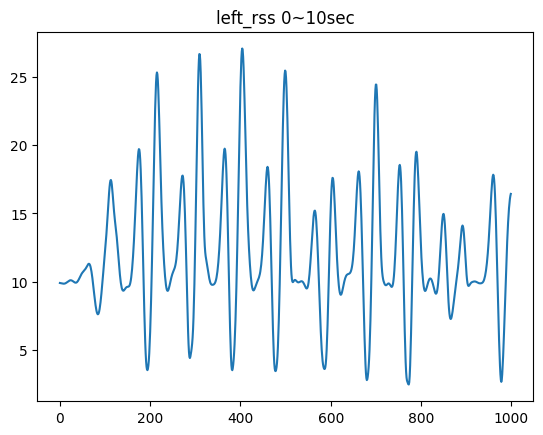

In [55]:
#Left x,y,z
left_acc_fft_x = low_pass_filter(data['LeftFootAcc']['x'],3.3,80,4)
left_acc_fft_y = low_pass_filter(data['LeftFootAcc']['y'],3.3,80,4)
left_acc_fft_z = low_pass_filter(data['LeftFootAcc']['z'],3.3,80,4)
#Right x,y,z
right_acc_fft_x = low_pass_filter(data['RightFootAcc']['x'],3.3,80,4)
right_acc_fft_y = low_pass_filter(data['RightFootAcc']['y'],3.3,80,4)
right_acc_fft_z = low_pass_filter(data['RightFootAcc']['z'],3.3,80,4)

#訊號倒置
left_acc_fft_x = np.array(left_acc_fft_x) * (-1)    
left_acc_fft_y = np.array(left_acc_fft_y) * (-1)  
left_acc_fft_z = np.array(left_acc_fft_z) * (-1)
#RSS
left_rss = np.sqrt(np.array(left_acc_fft_x)**2 + np.array(left_acc_fft_y)**2 + np.array(left_acc_fft_z)**2)
right_rss = np.sqrt(np.array(right_acc_fft_x)**2 + np.array(right_acc_fft_y)**2 + np.array(right_acc_fft_z)**2)
plt.plot(left_rss[0:1000])
plt.title('left_rss 0~10sec')

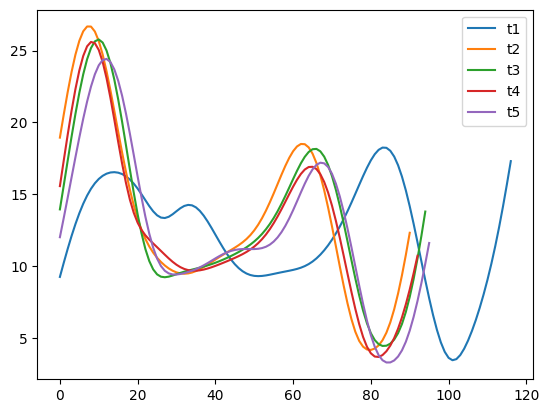

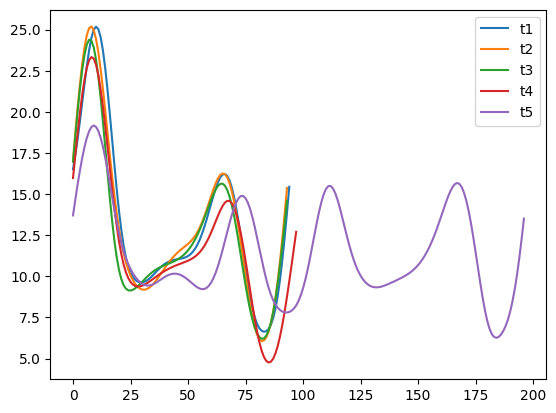

In [56]:
#left five steps
left_five = left_rss[Left_five_steps[0]:Left_five_steps[-1]]
left_t1 = left_rss[Left_five_steps[0]:Left_five_steps[1]]
left_t2 = left_rss[Left_five_steps[1]:Left_five_steps[2]]
left_t3 = left_rss[Left_five_steps[2]:Left_five_steps[3]]
left_t4 = left_rss[Left_five_steps[3]:Left_five_steps[4]]
left_t5 = left_rss[Left_five_steps[4]:Left_five_steps[5]]
plt.plot(left_t1,label='t1')
plt.plot(left_t2,label='t2')
plt.plot(left_t3,label='t3')
plt.plot(left_t4,label='t4')
plt.plot(left_t5,label='t5')

# for i in range(5):
#     locals()['t'+str(i)] = i+1 
#     label = locals()['t'+str(i)]
#     locals()['t'+str(i)] = left_rss[Left_five_steps[i]:Left_five_steps[i+1]]
#     plt.plot(locals()['t'+str(i)],label=f't{label}')
plt.legend()
plt.show()

#right five steps
right_five = right_rss[Right_five_steps[0]:Right_five_steps[-1]]    
right_t1 = right_rss[Right_five_steps[0]:Right_five_steps[1]]
right_t2 = right_rss[Right_five_steps[1]:Right_five_steps[2]]
right_t3 = right_rss[Right_five_steps[2]:Right_five_steps[3]]
right_t4 = right_rss[Right_five_steps[3]:Right_five_steps[4]]
right_t5 = right_rss[Right_five_steps[4]:Right_five_steps[5]]
plt.plot(right_t1,label='t1')
plt.plot(right_t2,label='t2')
plt.plot(right_t3,label='t3')
plt.plot(right_t4,label='t4')
plt.plot(right_t5,label='t5')

# for i in range(5):
#     locals()['t'+str(i)] = i+1 
#     label = locals()['t'+str(i)]
#     locals()['t'+str(i)] = left_rss[Left_five_steps[i]:Left_five_steps[i+1]]
#     plt.plot(locals()['t'+str(i)],label=label)
plt.legend()


切割

376
402
398
400
397
367 367 367 367 367 

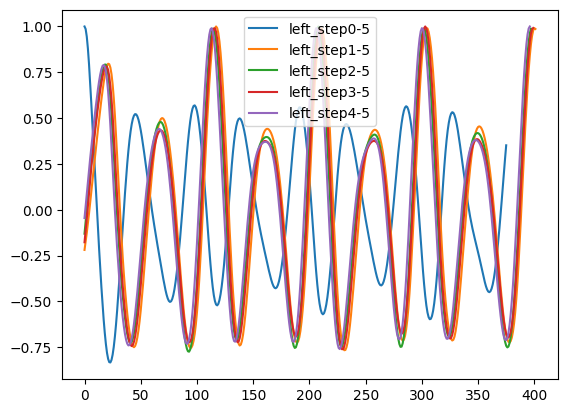

484
485
485
481
382
367 367 367 367 367 

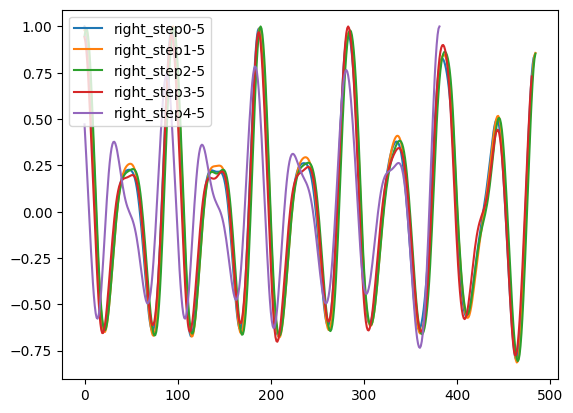

In [57]:
#left NCC(CrossCorrelation)
left_ncc_list = []
for i in range(5):
    a2 = NormaliseCrossCorrelation(left_five,left_rss[Left_five_steps[i]:Left_five_steps[i+1]])
    left_ncc_list.append(a2[0:367])
    plt.plot(a2,label=f'left_step{i}-5')
plt.legend()
for _ in range(5):print(len(left_ncc_list[_]),end=' ')
plt.show()
#right NCC(CrossCorrelation)
right_ncc_list = []
for i in range(5):
    a = NormaliseCrossCorrelation(right_five,right_rss[Right_five_steps[i]:Right_five_steps[i+1]])
    right_ncc_list.append(a[0:367])
    plt.plot(a,label=f'right_step{i}-5')
plt.legend()
for _ in range(5):print(len(right_ncc_list[_]),end=' ')
plt.show()

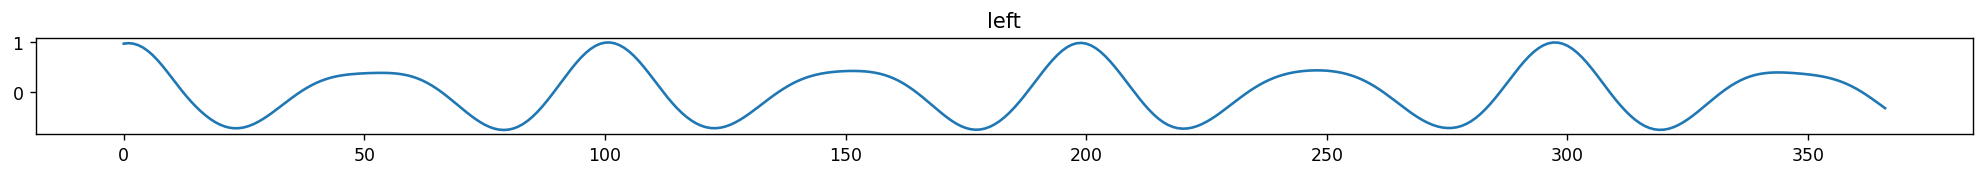

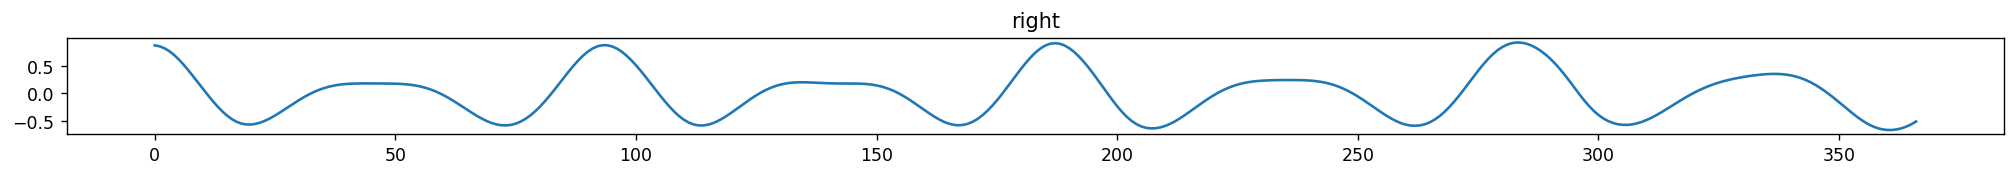

Ttest_relResult(statistic=0.5153572416596691, pvalue=0.6066145358926772)

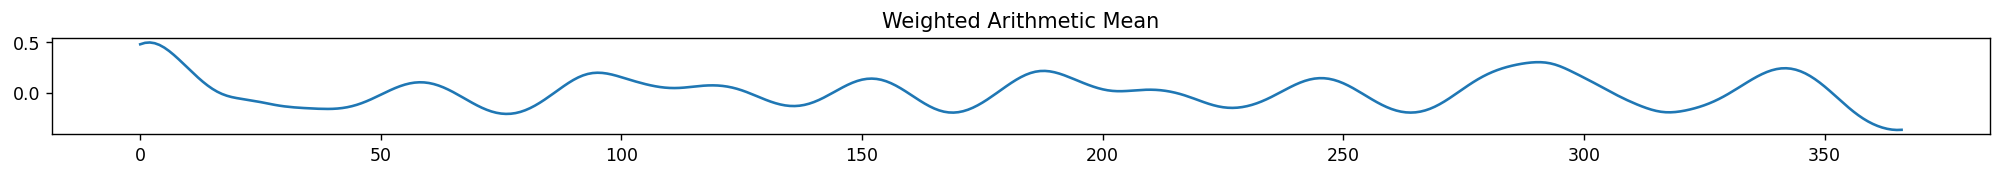

In [58]:
#left Ncc mean
left_ncc2 = np.mean(left_ncc_list, axis=0)
plt.figure(figsize=(20,1),dpi=125)
plt.plot(left_ncc1)
plt.title('left')
plt.show()
#right Ncc mean
right_ncc2 = np.mean(right_ncc_list, axis=0)
plt.figure(figsize=(20,1),dpi=125)
plt.plot(right_ncc2)
plt.title('right')
plt.show()
# total_ncc1 = [left_ncc1,right_ncc1]
# mean_ncc1 = np.mean(total_ncc1,axis=0)
# plt.figure(figsize=(20,1),dpi=125)
# plt.plot(mean_ncc1)
w1 = 0.5
w2 = 0.5
final_score2 = (w1 * left_ncc2 + w2 * right_ncc2) / (w1 + w2)
plt.figure(figsize=(20,1),dpi=125)
plt.plot(final_score2)
plt.title('Weighted Arithmetic Mean')
stats.ttest_rel(left_ncc2, right_ncc2)

In [59]:
#left(不分)
y = detect_peaks(left_ncc2*(-1),mpd = 35 )
left_ncc_area_twice=[]
for _ in range(len(y)):
    try:
        x_a=np.arange(y[_],y[_+1],1)
        y_a=left_ncc2[y[_]:y[_+1]]
        area = integrate.trapz(y_a, x_a)
        print(f'left 下面積{_+1}為：', area)
        left_ncc_area_twice.append(abs(area))
    except:break
print(left_ncc_area_twice)

left 下面積1為： -3.1580140420963514
left 下面積2為： 3.7359111591455
left 下面積3為： -1.882075352099613
left 下面積4為： 3.4098737181958825
left 下面積5為： -2.4526139505994955
left 下面積6為： 4.471309791104682
[3.1580140420963514, 3.7359111591455, 1.882075352099613, 3.4098737181958825, 2.4526139505994955, 4.471309791104682]


[ 40  91 135 186 228 281 324]
[-0.49331029 -0.4923384  -0.48466546 -0.47032731 -0.44950911 -0.42255667
 -0.38997145 -0.35239269 -0.31057124 -0.26533946 -0.21758054 -0.16819913
 -0.11809387 -0.06813187 -0.01912559  0.02818682  0.07315634  0.11523169
  0.153961    0.18898642  0.22003274  0.24689171  0.26940447  0.28744459
  0.300904    0.30968354  0.31368919  0.31283424  0.30704703  0.29628326
  0.28054089  0.25987492  0.23440853  0.20433764  0.16992763  0.13150429
  0.08944395  0.04416924 -0.00384579 -0.05406143 -0.10585384 -0.15849718
 -0.21115074 -0.26285528 -0.3125442  -0.35907496 -0.40128295 -0.43805259
 -0.46839251 -0.49149755 -0.50678245]
left 下面積1為： -3.1580140420963514
left 下面積2為： 3.7359111591455
left 下面積3為： -1.882075352099613
left 下面積4為： 3.4098737181958825
left 下面積5為： -2.4526139505994955
left 下面積6為： 4.471309791104682
[3.1580140420963514, 1.882075352099613, 2.4526139505994955]
[3.7359111591455, 3.4098737181958825, 4.471309791104682]
[91, 186, 281]
[40, 135, 228, 324]
[ 95 188 284

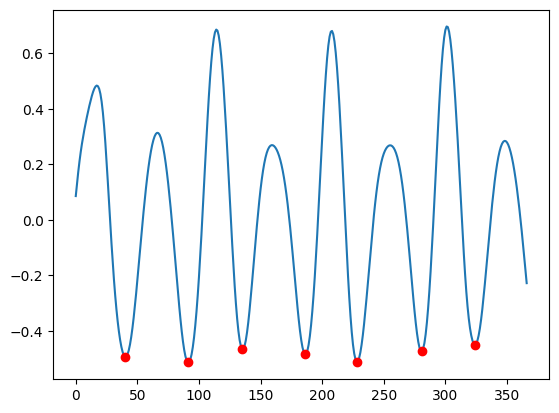

In [60]:
#left(分)
y = detect_peaks(left_ncc2*(-1),mpd = 35 )
print(y)
plt.plot(left_ncc2)
plt.plot(y,left_ncc2[y],'o',color='r')
print(left_ncc2[y[0]:y[1]]) #y值
left_ncc_area1 = []
left_ncc_area2 = []
for _ in range(len(y)):
    try:
        x_a=np.arange(y[_],y[_+1],1)
        y_a=left_ncc2[y[_]:y[_+1]]
        area = integrate.trapz(y_a, x_a)
        print(f'left 下面積{_+1}為：', area)
    except:break
    if (_+1)%2 == 1:left_ncc_area1.append(abs(area))
    if (_+1)%2 == 0:left_ncc_area2.append(abs(area))
print(left_ncc_area1)
print(left_ncc_area2)
left_small_ncc2=left_ncc_area1
left_big_ncc2=left_ncc_area2

left_small_ncc2_st = [_ for _ in y if int(list(np.where(y==_))[0])%2==1]
print(left_small_ncc2_st)
left_big_ncc2_st = [_ for _ in y if int(list(np.where(y==_))[0])%2==0]
print(left_big_ncc2_st)
left_small_ncc2_st = left_small_ncc2_st-left_big_ncc2_st[0]
left_big_ncc2_st = (left_big_ncc2_st-left_big_ncc2_st[0])[1::]
print(left_big_ncc2_st)

In [61]:
#right(不分)
y = detect_peaks(right_ncc2*(-1),mpd = 35 )
right_ncc_area_twice=[]
for _ in range(len(y)):
    try:
        x_b=np.arange(y[_],y[_+1],1)
        y_b=right_ncc2[y[_]:y[_+1]]
        area = integrate.trapz(y_b, x_b)
        print(f'right 下面積{_+1}為：', area)
        right_ncc_area_twice.append(abs(area))
    except:break
print(right_ncc_area_twice)

right 下面積1為： -4.269757018998353
right 下面積2為： 5.466043339390184
right 下面積3為： -2.928666782285349
right 下面積4為： 5.7573201210908715
right 下面積5為： -3.972651408714813
right 下面積6為： 7.393469845676603
right 下面積7為： -2.6720126310429144
[4.269757018998353, 5.466043339390184, 2.928666782285349, 5.7573201210908715, 3.972651408714813, 7.393469845676603, 2.6720126310429144]


[ 20  73 114 167 207 262 306 361]
[-0.56187899 -0.54949341 -0.52513316 -0.49064957 -0.44791965 -0.3988074
 -0.34514751 -0.28872634 -0.23125172 -0.17431413 -0.11934542 -0.0675801
 -0.02002277  0.02257579  0.0597314   0.09122668  0.1170977   0.13760785
  0.15321088  0.16450567  0.17218612  0.17698888  0.17964181  0.18081565
  0.18108107  0.18087298  0.1804638   0.1799468   0.17923028  0.17804296
  0.17595041  0.17238194  0.16666713  0.1580803   0.14589118  0.12941893
  0.10808628  0.08146995  0.04934339  0.01170859 -0.03118506 -0.078835
 -0.1304912  -0.18517103 -0.24168101 -0.29864403 -0.35453241 -0.40770789
 -0.45646979 -0.49911177 -0.5339858  -0.55956967 -0.57453221]
right 下面積1為： -4.269757018998353
right 下面積2為： 5.466043339390184
right 下面積3為： -2.928666782285349
right 下面積4為： 5.7573201210908715
right 下面積5為： -3.972651408714813
right 下面積6為： 7.393469845676603
right 下面積7為： -2.6720126310429144
right 下面積為： -4.269757018998353
[4.269757018998353, 2.928666782285349, 3.972651408714813, 2.6720126310

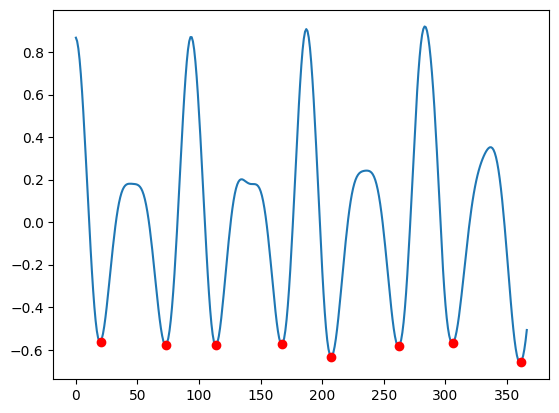

In [62]:
#right(分)
x = detect_peaks(right_ncc2,mpd = 80 )
y = detect_peaks(right_ncc2*(-1),mpd = 35 )
print(y)
plt.plot(right_ncc2)
plt.plot(y,right_ncc2[y],'o',color='r')
print(right_ncc2[y[0]:y[1]]) #y值
right_ncc_area1 = []
right_ncc_area2 = []
for _ in range(len(y)):
    try:
        x_b=np.arange(y[_],y[_+1],1)
        y_b=right_ncc2[y[_]:y[_+1]]
        area = integrate.trapz(y_b, x_b)
        print(f'right 下面積{_+1}為：', area)
    except:break
    if (_+1)%2 == 1:right_ncc_area1.append(abs(area))
    if (_+1)%2 == 0:right_ncc_area2.append(abs(area))
x_b=np.arange(y[0],y[1],1)
y_b=right_ncc2[y[0]:y[1]]
area = integrate.trapz(y_b, x_b)
print('right 下面積為：', area)
print(right_ncc_area1)
print(right_ncc_area2)
right_small_ncc2=right_ncc_area1
right_big_ncc2=right_ncc_area2

right_small_ncc2_st = [_ for _ in y if int(list(np.where(y==_))[0])%2==1]
print(right_small_ncc2_st)
right_big_ncc2_st = [_ for _ in y if int(list(np.where(y==_))[0])%2==0]
print(right_big_ncc2_st)
right_small_ncc2_st = right_small_ncc2_st-right_big_ncc2_st[0]
right_big_ncc2_st = (right_big_ncc2_st-right_big_ncc2_st[0])[1::]
print(right_big_ncc2_st)

(後次)儲存NCC面積序列至.csv

In [63]:
print(left_ncc_area1)
#Left
left_area = []
if isinstance(left_ncc_area1[0],float) is True:
    for _ in range(len(left_ncc_area1) + len(left_ncc_area2)):
        try:
            left_area.append(left_ncc_area1[_])
            left_area.append(left_ncc_area2[_])
        except:break
    left_area.insert(0,'後次左腳NCC面積序列')
with open (f'{origin_path}/{filename}.csv','a') as f:
    writer = csv.writer(f)
    writer.writerow(left_area)
#Right
right_area = []
if isinstance(right_ncc_area1[0],float) is True:
    for _ in range(len(right_ncc_area1) + len(right_ncc_area2)):
        try:
            right_area.append(right_ncc_area1[_])
            right_area.append(right_ncc_area2[_])
        except:break
    right_area.insert(0,'後次右腳NCC面積序列')
with open (f'{origin_path}/{filename}.csv','a') as f:
    writer = csv.writer(f)
    writer.writerow(right_area)
print(left_area)
print(origin_path)

[3.1580140420963514, 1.882075352099613, 2.4526139505994955]
['後次左腳NCC面積序列', 3.1580140420963514, 3.7359111591455, 1.882075352099613, 3.4098737181958825, 2.4526139505994955, 4.471309791104682]
./05.台南北華里/000可用data/021


In [64]:
# left_small_ncc1 = [-8.374758043724771, -5.435695567954948, -5.967190603826191]
# left_big_ncc1 = [8.441113788018024, 8.34969507794602, 5.820116969101004]
# right_small_ncc1 = [-5.268211379239522, -5.671379244591854, -6.101241151491957]
# right_big_ncc1 = [6.671533889206698, 6.2814370648711515, 6.958109435728631]

# left_small_ncc2 = [-6.244779117156478, -6.100758447463125, -6.375073811909519, -5.862492474241352]
# left_big_ncc2 = [7.84339862473965, 7.026514791818825, 7.710889480485574]
# right_small_ncc2 = [-6.779658215030557, -6.789940605136771, -6.959439178882285, -5.649964884301156]
# right_big_ncc2 = [7.592230866751745, 8.398466815519022, 6.4201399615050105]
print('前')
print(f'left_small_ncc1:{left_small_ncc1}')
print(f'left_big_ncc1:{left_big_ncc1}')
print(f'right_small_ncc1:{right_small_ncc1}')
print(f'right_big_ncc1:{right_big_ncc1}')
print('後')
print(f'left_small_ncc2:{left_small_ncc2}')
print(f'left_big_ncc2:{left_big_ncc2}')
print(f'right_small_ncc2:{right_small_ncc2}')
print(f'right_big_ncc2:{right_big_ncc2}')


前
left_small_ncc1:[3.4060878660434764, 2.2512625625092806, 3.06434000952441]
left_big_ncc1:[4.229547028334744, 3.995984775951407, 4.334611023949372]
right_small_ncc1:[5.895610467633777, 4.194166368345613, 5.5256903431568585]
right_big_ncc1:[6.120816734597312, 5.2309561253867125, 6.331345207906111]
後
left_small_ncc2:[3.1580140420963514, 1.882075352099613, 2.4526139505994955]
left_big_ncc2:[3.7359111591455, 3.4098737181958825, 4.471309791104682]
right_small_ncc2:[4.269757018998353, 2.928666782285349, 3.972651408714813, 2.6720126310429144]
right_big_ncc2:[5.466043339390184, 5.7573201210908715, 7.393469845676603]


In [65]:
# print(left_ncc_area_once)
# print(right_ncc_area_once)
# print(left_ncc_area_twice)
# print(right_ncc_area_twice)
# a=[1.9305627670509444,2.2300293195343817, 0.8662815243172557,2.2421309300314842, 2.0141193856385646,4.691610743661301, 1.344386883607363]
# b=[2.9136377514163128,3.471816886003646, 2.597887324333702,3.762041921591632, 2.147259685879987,3.758354461544877, 2.689753720057027]
# c=[]
# if len(a)>len(b):
#     c=[_ for _ in b[0:len(b)]]
#     print(stats.ttest_rel(b, c))
# if len(b)>len(a):
#     c=[_ for _ in b[0:len(a)]]
#     print(stats.ttest_rel(a, c))
# else:print(stats.ttest_rel(a,b))
#print(len(ncc1),len(ncc2))
# t_statistic, p_values = stats.ttest_ind(ncc1, ncc2, equal_var=False)
# print(stats.ttest_rel(left_ncc_area_once, left_ncc_area_twice))
# print(stats.ttest_rel(right_ncc_area_once, right_ncc_area_twice))
# print("t-statistic:", t_statistic)
# print("p-value:", p_values)

In [66]:
from scipy.stats import ttest_ind
a = [[-8.374758043724771,52],[-5.435695567954948,146],[-5.967190603826191,237]]
b = [[-6.244779117156478,45],[-6.100758447463125,130],[-6.375073811909519,216]]
t, p = ttest_ind(left_ncc_area_once, left_ncc_area_twice[0:6], equal_var=False)

print("t值：", t)
print("p值：", p)

t值： 0.7258074099663133
p值： 0.48490315654500216


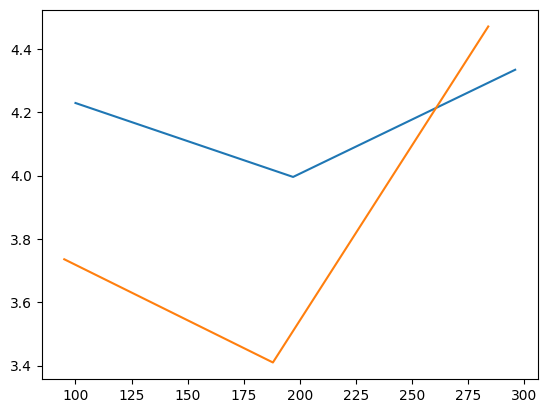

T-test結果：
T值： [0.11025861 0.95408014]
p值： [0.91752148 0.42590038]


In [67]:
plt.plot(left_big_ncc1_st,left_big_ncc1)
plt.plot(left_big_ncc2_st,left_big_ncc2)
plt.show()
x1=np.array(left_big_ncc1_st)
y1=np.array(left_big_ncc1)
x2=np.array(left_big_ncc2_st)
y2=np.array(left_big_ncc2)

data1 = np.column_stack((x1, y1))
data2 = np.column_stack((x2, y2))


from scipy.stats import ttest_ind

t, p = ttest_ind(data1, data2, equal_var=False)
print("T-test結果：")
print("T值：", t)
print("p值：", p)

In [68]:
from scipy.stats import ttest_ind
a=[38.01,18.45,30.86,15.50,59.95,29.03,40.86,58.25,21.67,36.57,26.90,20.75,35.25]
b=[11.68,10.54,11.69,8.37,9.85,8.98,17.31,8.01,8.79,17.57,9.81,9.27,8.16]
c=[23.25,13.18,15.15,12.23,31.47,15.70,23.56,16.92,27.36,38.16,29.08,52.85,27.26]
print(stats.ttest_rel(b, c))
print(ttest_ind(b,c))

Ttest_relResult(statistic=-4.560678842718707, pvalue=0.0006539553474590457)
Ttest_indResult(statistic=-4.341690324268785, pvalue=0.00022153787830450725)
